In [19]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

import six
import sys
sys.modules['sklearn.externals.six'] = six

from IPython.display import Image
import six
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
import pydotplus, graphviz


In [2]:
housing = pd.read_csv("Housing.csv")

In [3]:
varlist = ['mainroad', 'guestroom', 'basement',
           'hotwaterheating', 'airconditioning', 'prefarea']

housing[varlist] = housing[varlist].apply(lambda x: x.map({'yes':1, 'no':0}))
housing[varlist].head(5)

,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea
0,1,0,0,0,1,1
1,1,0,0,0,1,0
2,1,0,1,0,0,1
3,1,0,1,0,1,1
4,1,1,1,0,1,0


In [4]:
status = pd.get_dummies(housing['furnishingstatus'], dtype = int, drop_first=True)

In [5]:
housing = pd.concat([housing, status], axis = 1)

In [6]:
housing = housing.drop('furnishingstatus', axis = 1)

In [7]:
np.random.seed(0)
df_train, df_test = train_test_split(housing, train_size=0.7, random_state=100)

In [8]:
dt = DecisionTreeRegressor(random_state=42, max_depth=4, min_samples_leaf=10)

In [9]:
scaler = MinMaxScaler()

In [10]:
df_train['price'] = scaler.fit_transform(df_train[['price']])
df_test['price'] = scaler.fit_transform(df_test[['price']])

In [11]:
y_train = df_train.pop('price')
X_train = df_train

y_test = df_test.pop('price')
X_test = df_test

In [12]:
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4, min_samples_leaf=10, random_state=42)

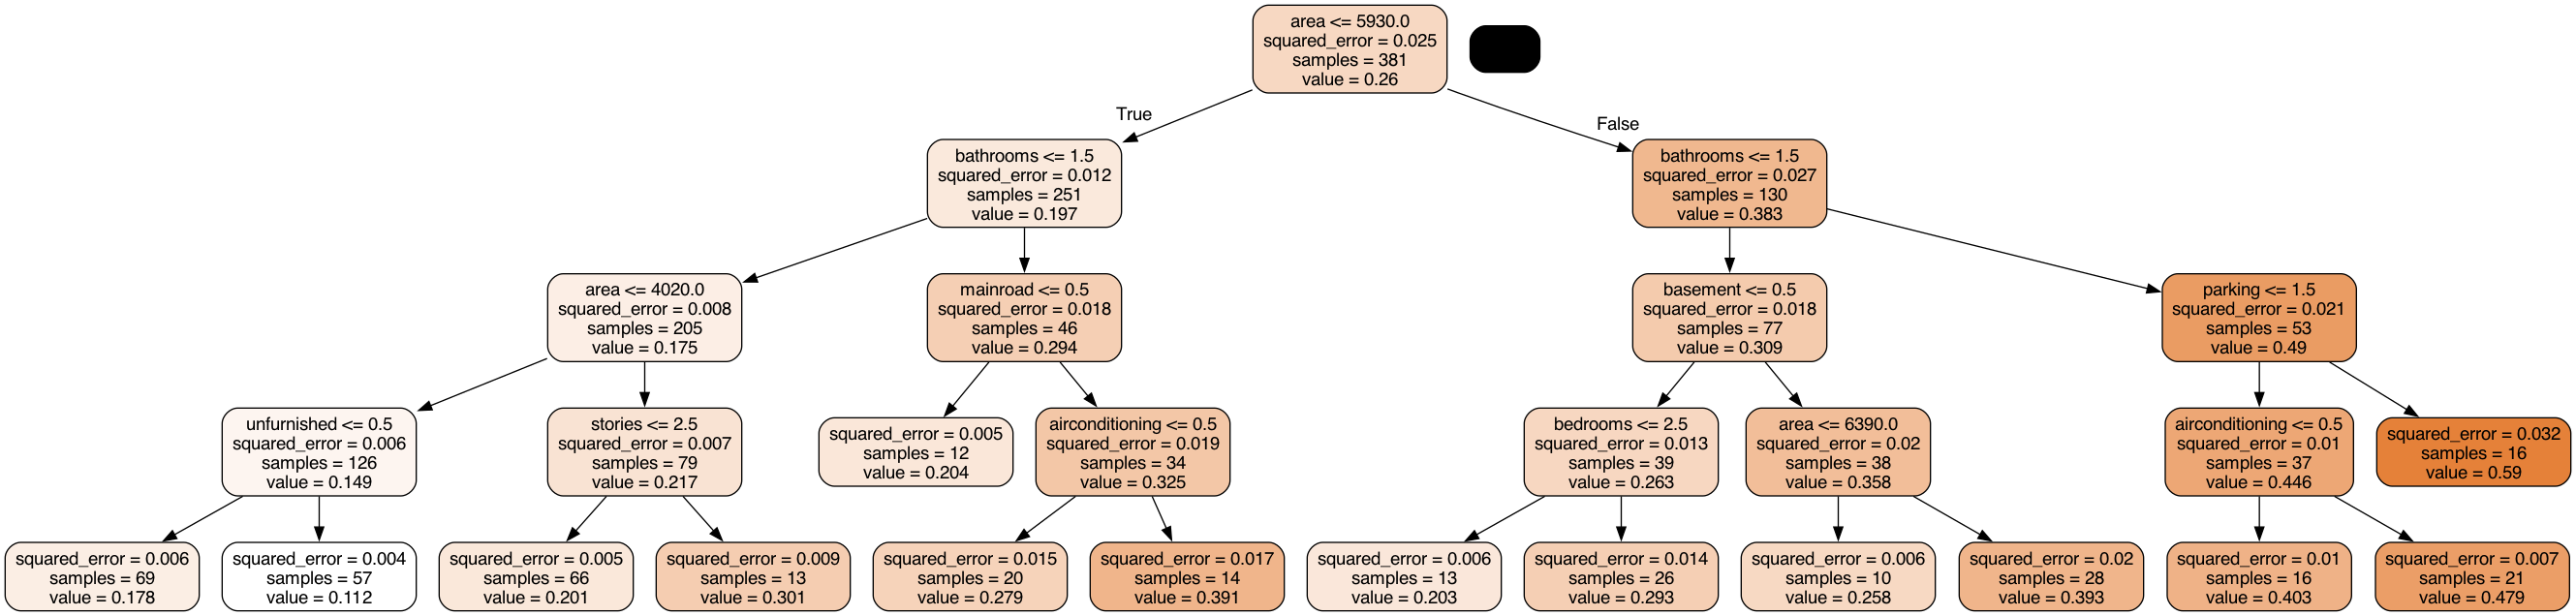

In [18]:
dot_data = StringIO()

export_graphviz(dt, out_file=dot_data, filled = True, rounded = True,
                feature_names=X_train.columns)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [20]:
y_train_pred = dt.predict(X_train)
r2_score(y_train, y_train_pred)

0.6234560022579934

In [22]:
y_test_pred = dt.predict(X_test)
r2_score(y_test, y_test_pred)

0.5130740021517648

### Hyper-parameter tuning

In [23]:
from sklearn.model_selection import GridSearchCV

In [24]:
dt = DecisionTreeRegressor(random_state=42)

In [28]:
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100],
    'criterion': ['absolute_error', 'friedman_mse', 'squared_error', 'poisson']
}

In [33]:
grid_search = GridSearchCV(estimator=dt,
             param_grid=params,
             cv=4, # 4-fold validation, which means 1/4 of the data would be used for testing, splits into 75:25 ratio
             n_jobs = -1, verbose = 1,
             scoring = 'r2')

In [34]:
%%time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 100 candidates, totalling 400 fits
CPU times: user 88.6 ms, sys: 18.9 ms, total: 108 ms
Wall time: 224 ms


GridSearchCV(cv=4, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['absolute_error', 'friedman_mse',
                                       'squared_error', 'poisson'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='r2', verbose=1)

In [35]:
cv_df = pd.DataFrame(grid_search.cv_results_)
cv_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.032237,0.019410,0.001666,0.000254,absolute_error,2,5,"{'criterion': 'absolute_error', 'max_depth': 2...",0.463147,0.182513,0.366069,0.365939,0.344417,0.101540,59
1,0.004805,0.002527,0.000733,0.000263,absolute_error,2,10,"{'criterion': 'absolute_error', 'max_depth': 2...",0.463147,0.182513,0.366069,0.365939,0.344417,0.101540,59
2,0.002223,0.000125,0.000410,0.000031,absolute_error,2,20,"{'criterion': 'absolute_error', 'max_depth': 2...",0.463147,0.368775,0.366069,0.365939,0.390982,0.041679,58
3,0.001957,0.000586,0.000423,0.000124,absolute_error,2,50,"{'criterion': 'absolute_error', 'max_depth': 2...",0.312256,0.130783,0.228942,0.239603,0.227896,0.064587,100
4,0.001915,0.000428,0.000592,0.000228,absolute_error,2,100,"{'criterion': 'absolute_error', 'max_depth': 2...",0.304886,0.365540,0.272158,0.165174,0.276940,0.072707,75


In [36]:
cv_df.nlargest(5, 'mean_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
91,0.000652,0.000036,0.000395,0.000098,poisson,10,10,"{'criterion': 'poisson', 'max_depth': 10, 'min...",0.585874,0.557405,0.470166,0.393072,0.501629,0.075800,1
96,0.001625,0.000771,0.000632,0.000360,poisson,20,10,"{'criterion': 'poisson', 'max_depth': 20, 'min...",0.585874,0.557405,0.470166,0.393072,0.501629,0.075800,1
86,0.000749,0.000043,0.000410,0.000081,poisson,5,10,"{'criterion': 'poisson', 'max_depth': 5, 'min_...",0.586587,0.551327,0.468362,0.392157,0.499608,0.075436,3
12,0.004535,0.001838,0.000780,0.000200,absolute_error,5,20,"{'criterion': 'absolute_error', 'max_depth': 5...",0.582464,0.555982,0.463608,0.392642,0.498674,0.075461,4
17,0.002630,0.000538,0.000368,0.000045,absolute_error,10,20,"{'criterion': 'absolute_error', 'max_depth': 1...",0.582464,0.555982,0.463608,0.392642,0.498674,0.075461,4


In [37]:
grid_search.best_score_

0.5016294644619508

In [38]:
grid_search.best_estimator_

DecisionTreeRegressor(criterion='poisson', max_depth=10, min_samples_leaf=10,
                      random_state=42)